# K-NearestNeighbour Sex Classification

### Initial Setup

In [1]:
import numpy as np
import networkx as nx
import scipy as sp
import matplotlib.pyplot as plt
import os
import csv

from collections import OrderedDict
from sklearn import cross_validation
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

font = {'weight' : 'bold',
        'size'   : 18}

import matplotlib
matplotlib.rc('font', **font)

np.random.seed(12345678)  # for reproducibility, set random seed

### Getting File Lists

In [2]:
# Initializing dataset names
dataset_names = list(('KKI2009', 'MRN114', 'SWU4', 'BNU1', 'BNU3'))
# dataset_names = list(('KKI2009', 'MRN114', 'BNU1', 'BNU3'))

basepath = '/Users/gkiar/code/classes/upward-spiral/grelliam/data/'
atlas = 'desikan'
dir_names = [basepath + '/' + atlas + '/' + d for d in dataset_names]

#  Crawls directories and creates a dictionary entry of file names for each
#  dataset which we plan to process.
fs = OrderedDict()
for idx, dd in enumerate(dataset_names):
    fs[dd] = [root + "/" + fl for root, dirs, files in os.walk(dir_names[idx])
              for fl in files if fl.endswith(".graphml")]

ps = {os.path.splitext(os.path.basename(fl))[0] : root + "/" + fl
      for root, dirs, files in os.walk(basepath+'phenotypes')
      for fl in files if fl.endswith(".csv") }

print "Datasets: " + ", ".join([fkey + ' (' + str(len(fs[fkey])) + ')'
                                for fkey in fs])


Datasets: KKI2009 (42), MRN114 (114), SWU4 (454), BNU1 (81), BNU3 (46)


### Declaring Graph Read Helper Functions

In [3]:
def loadGraphs(filenames, verb=False):
    """
    Given a list of files, returns a dictionary of graphs

    Required parameters:
        filenames:
            - List of filenames for graphs
    Optional parameters:
        verb:
            - Toggles verbose output statements
    """
    #  Initializes empty dictionary
    gstruct = OrderedDict()
    for idx, files in enumerate(filenames):
        if verb:
            print "Loading: " + files
        #  Adds graphs to dictionary with key being filename
        fname = os.path.basename(files)
        gstruct[fname] = nx.read_graphml(files)
    return gstruct

def constructGraphDict(names, fs, verb=False):
    """
    Given a set of files and a directory to put things, loads graphs.

    Required parameters:
        names:
            - List of names of the datasets
        fs:
            - Dictionary of lists of files in each dataset
    Optional parameters:
        verb:
            - Toggles verbose output statements
    """
    #  Loads graphs into memory for all datasets
    graphs = OrderedDict()
    for idx, name in enumerate(names):
        if verb:
            print "Loading Dataset: " + name
        # The key for the dictionary of graphs is the dataset name
        graphs[name] = loadGraphs(fs[name], verb=verb)
    return graphs

### Reading Graphs

In [4]:
graphs = constructGraphDict(dataset_names, fs, verb=False)

### Reading Phenotypes

In [5]:
phenotypes = OrderedDict()
for dataset in dataset_names:
    tmp = csv.reader(open(ps[dataset]))
    pheno = OrderedDict()
    if dataset == 'KKI2009':
        triple = [[t[1].strip(), t[4], int(t[5] == 'M')] for t in tmp][1:]  # female=F->0, male=M->1
    elif dataset == 'MRN114':
        triple = [[t[0].strip(), t[3], int(t[2] == '1')] for t in tmp][1:]  # female=0->0, male=1->1
    else:
        triple = [[t[0].strip(), t[2], int(t[3] == '2')] for t in tmp
                  if t[3] != '#' and t[2] != '#'][1:]  # female=1->0, male=2->1
    
    for idx, trip in enumerate(triple):
        pheno[trip[0]] = trip[1:]
    phenotypes[dataset] = pheno

### Converting Graphs to Vectors and Phenotypes to List

In [6]:
N = nx.number_of_nodes(graphs[graphs.keys()[0]][graphs[graphs.keys()[0]].keys()[0]])
feat = np.empty((0, int(sp.special.binom(N,2))), int)
dats = list(())
ages = np.array(())
sexy = np.array(())

for idx1, dset in enumerate(graphs):
    for idx2, subj in enumerate(graphs[dset]):
        A = nx.adjacency_matrix(graphs[dset][subj]).todense()
        Au = A[np.triu_indices(A.shape[0], 1)]
        feat = np.append(feat, Au, axis=0)
        dats.append(dset)

        try:
            subj_id = str(int(subj.split('_')[1]))
        except:
            subj_id = subj.split('_')[1]
        
        ages = np.append(ages, int(phenotypes[dset][subj_id][0]))
        sexy = np.append(sexy, int(phenotypes[dset][subj_id][1]))

# print feat.shape, ages.shape, sexy.shape
# print sum(sexy == 0), sum(sexy == 1)
# print dats

### Classify Graphs

##### KNN LOO Subject Cross Validation

In [ ]:
"""
This is commented out because it's slow and not actually what I want to do :D
"""
# for i in np.arange(20):
#     classif = KNeighborsClassifier(n_neighbors=2*(i+1)-1)
#     loo = LeaveOneOut(len(sexy))
#     score = cross_validation.cross_val_score(classif, feat, sexy, cv=loo)
#     print("Accuracy for community size %d: %0.2f (+/- %0.2f)" % (2*(i+1)-1, score.mean(), score.std() * 2))

##### KNN LOO Dataset

In [9]:
knn = OrderedDict()
for i in np.arange(20):
    classif = KNeighborsClassifier(n_neighbors=2*(i+1)-1)
#     print "============="
#     print "K nearest Neighbors: %d" % (2*(i+1)-1)
    tmp = np.array(())
    for idx, dset in enumerate(dataset_names):
        ind = np.array([dset == d for d in dats])
        ft_train = feat[ind < 1] # current dataset is test
        ft_test = feat[ind >= 1] # all others are train
        sx_train = sexy[ind < 1]
        sx_test = sexy[ind >= 1]
        classif.fit(ft_train, sx_train)
        score = classif.score(ft_test, sx_test)
#         score = max( classif.score(ft_test, sx_test), 1 - classif.score(ft_test, sx_test))
        tmp = np.append(tmp, score)
#         print "~~~~~~~~~~~~"
#         print "Left out dataset: %s" % (dset)
#         print "Train: %d ; Test: %d" % (sx_train.shape[0], sx_test.shape[0])
#         print "Chance: %0.5f (%0.5f)" % (sum(sx_test)/len(sx_test), 1-sum(sx_test)/len(sx_test)) 
#         print "Classification Accuracy: %.5f (%0.5f)" % (score, 1-score)
    knn[i] = tmp

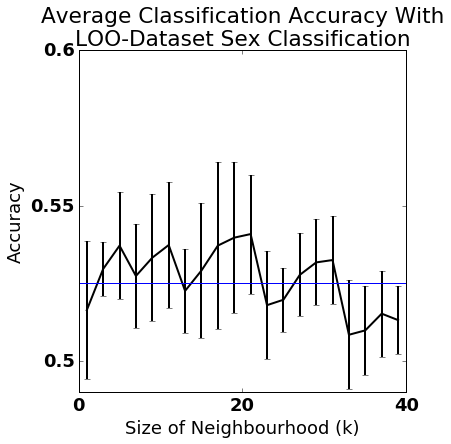

In [10]:
fig = plt.figure(figsize=(6,6))
mean = [np.mean(knn[i]) for i in knn]
stder = [np.std(knn[i])/np.sqrt(len(dataset_names)) for i in knn]
plt.errorbar((np.arange(20)+1)*2-1,mean, stder, lw = 2, color='#000000')
plt.yticks((0.5, 0.55, 0.6),(0.5, 0.55, 0.6))
plt.xticks((0, 20, 40),(0, 20, 40))
plt.xlabel('Size of Neighbourhood (k)')
plt.ylabel('Accuracy')
plt.title('Average Classification Accuracy With\nLOO-Dataset Sex Classification')
plt.axhline(sum(sexy)/len(sexy))
plt.tight_layout(0.01)
plt.show()

(70, 70) (1, 2415)


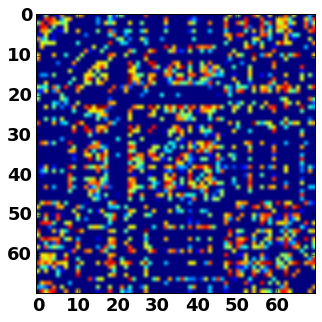

In [30]:
g1 = graphs['KKI2009']['KKI2009_113_1_desikan.graphml']
A = nx.adjacency_matrix(g1).todense()
ind = np.triu_indices(A.shape[0], 1)
Au = A[ind]
print A.shape, Au.shape
fig = plt.figure(figsize=(5,5))
plt.imshow(np.log(A+1), interpolation=None)
plt.show()